# Predição de CRA com Regressão

Importar bibliotecas, incluindo os modelos de regressão

In [47]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import  validation_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

Inicialização da variável global que armazena as características enviesadas

In [ ]:
inclinacao = 0;

Função de leitura, organização e separação dos rótulos dos dados de TREINAMENTO

In [2]:
def read_data(file):
	data = pd.read_csv(file)
	#reorganiza os dados
	data = pd.concat([data.loc[:,'Vetorial':'LP2'], data.loc[:,'Cálculo1'], data.loc[:,'cra']], axis=1)
	#separa os dados
	X = data.loc[:,'Vetorial':'Cálculo1']
	Y = data.loc[:,'cra']
	return[X,Y]

Função de leitura, organização e separação dos rótulos dos dados de TESTE

In [3]:
def getvalue(data, col_name):
	result = np.mean(data[data["DISCIPLINA"] == col_name].loc[:,"MAT_MEDIA_FINAL"].values)
	return 0 if math.isnan(result) else result

def organize_test_data(file):
	data_treino = pd.read_csv(file)
	#reorganiza os dados
	data_treino = pd.concat([data_treino.loc[:,"ALU_NOVAMATRICULA"], data_treino.loc[:,'DISCIPLINA':'MAT_MEDIA_FINAL']], axis=1)
	data_treino.loc[:,"MAT_MEDIA_FINAL"] = data_treino.loc[:,"MAT_MEDIA_FINAL"].fillna(0)
	matriculas = data_treino["ALU_NOVAMATRICULA"].unique()
	colunas = ["Vetorial","LPT","P1","IC","LP1","Cálculo2","Discreta","P2","Grafos","Fís.Clássica","LP2","Cálculo1","cra"]
	notas = np.zeros((matriculas.size,np.size(colunas)))
	count = 0
	for i in matriculas:
		result = data_treino[data_treino["ALU_NOVAMATRICULA"] == i]
		cred = result.loc[:,"CREDITOS"]  
		nota = result.loc[:,"MAT_MEDIA_FINAL"]
		cra = np.dot(cred.T,nota)/np.sum(cred)
		vetorial = getvalue(result,"Álgebra Vetorial e Geometria Analítica")
		lpt = getvalue(result,"Leitura e Produção de Textos")
		p1 = getvalue(result,"Programação I")
		ic = getvalue(result,"Introdução à Computação")
		lp1 = getvalue(result,"Laboratório de Programação I")
		calculo2 = getvalue(result,"Cálculo Diferencial e Integral II")
		discreta = getvalue(result,"Matemática Discreta")
		p2 = getvalue(result,"Programação I")
		grafos = getvalue(result,"Teoria dos Grafos")
		fisclassica = getvalue(result,"Fundamentos de Física Clássica")
		lp2 = getvalue(result,"Laboratório de Programação II")
		calculo1 = getvalue(result,"Cálculo Diferencial e Integral I")
		notas[count,:] = [vetorial,lpt,p1,ic,lp1,calculo2,discreta,p2,grafos,fisclassica,lp2,calculo1,cra]
		count += 1
	df = pd.DataFrame(notas, index=matriculas, columns=colunas)		
	pd.concat([df.loc[:,'Vetorial':'LP2'], df.loc[:,'Cálculo1'], df.loc[:,'cra']], axis=1)
	#separa os dados
	X = df.loc[:,'Vetorial':'Cálculo1']
	Y = df.loc[:,'cra']
	return[X,Y]

Função que adiciona a característica MÉDIA ao conjunto de características

In [4]:
def add_mean(X):
	media = np.sum(X,axis=1)/12
	X = pd.concat([X,media], axis=1)
	return X

Função que aplica a função log nos dados com determinado nível de enviesamento

In [5]:
def skew_data(X,threshold):
	global inclinacao
	inclinacao = X[:].apply(lambda x: skew(x))
	inclinacao = inclinacao[abs(inclinacao) > threshold]
	inclinacao = inclinacao.index
	X[inclinacao] = np.log1p(X[inclinacao])
	return X

Função que cria variaveis polinomiais ao conjunto de características

In [7]:
def add_poly_feat(X, degree):
	poly = PolynomialFeatures(degree)
	return poly.fit_transform(X)

Função que imprime o RMSE do treino de da validação de acordo com a variação do parametro do modelo escolhido

In [8]:
def print_rmse(train,validation,param, range, name):
    result = np.concatenate((train[:,np.newaxis], validation[:,np.newaxis]), axis=1)
    result = pd.DataFrame(result, index=range, columns=['Train','Validation'])
    print("{0} - {1} versus RMSE \n {2} \n".format(name, param, result))

Função que plota o gráfico do treino de da validação RMSE de acordo com a variação do parametro do modelo escolhido

In [9]:
def plot_rmse(train,validation,param, range, name):
	plt.xlabel(param)
	plt.ylabel('RMSE')
	plt.title(name)
	line1, = plt.plot(range, validation, label="Validation")
	line2, = plt.plot(range, train, label="Train")
	first_legend = plt.legend(handles=[line1], loc=1)
	ax = plt.gca().add_artist(first_legend)
	plt.legend(handles=[line2], loc=4)
	plt.show()

Função que calcula o RMSE do treino de da validação de acordo com a variação do parametro do modelo escolhido

In [14]:
def calc_rmse(model,param,range,name):
    [train,validation] = validation_curve(model, X, Y, scoring="neg_mean_squared_error", param_name=param, param_range=range, cv = 5)
    train = np.sqrt(-train)
    validation = np.sqrt(-validation)
    train = train.mean(axis=1)
    validation = validation.mean(axis=1)
    print_rmse(train,validation,param, range, name)
    plot_rmse(train,validation,param, range, name)
    #recupera o melhor parametro e retorna o melhor modelo
    params = {param:range[np.argmin(validation)]}
    model.set_params(**params)
    model.fit(X,Y)
    return model

Função que plota os resíduos versus predições

In [15]:
def graph_res_pred(model,X,Y,name):
	preds = pd.DataFrame({"preds":model_ridge.predict(X), "true":Y})
	preds["residuals"] = preds["true"] - preds["preds"]
	preds.plot(x = "preds", y = "residuals",kind = "scatter")
	plt.show()  

Leitura dos dados de treinamento, adição da característica MEDIA aplicação da função log nos dados enviesados

In [36]:
[X,Y] = read_data("treino.csv")
X = add_mean(X)
X = skew_data(X,0.4)

Treinamento do modelo de Regressão Linear Ridge, inclusive sem regularização (alpha = 0) 

Ridge Regression - alpha versus RMSE 
            Train  Validation
0.00    0.473899    0.603042
0.05    0.477502    0.592844
0.10    0.478499    0.587163
0.20    0.480358    0.579838
0.30    0.482042    0.575219
0.40    0.483517    0.571956
1.00    0.489340    0.562200
3.00    0.496576    0.551801
5.00    0.499439    0.547243
10.00   0.502963    0.541420
15.00   0.505223    0.538438
30.00   0.510881    0.535297
50.00   0.518125    0.536374
60.00   0.521710    0.537917
75.00   0.527029    0.540908
100.00  0.535703    0.546929 



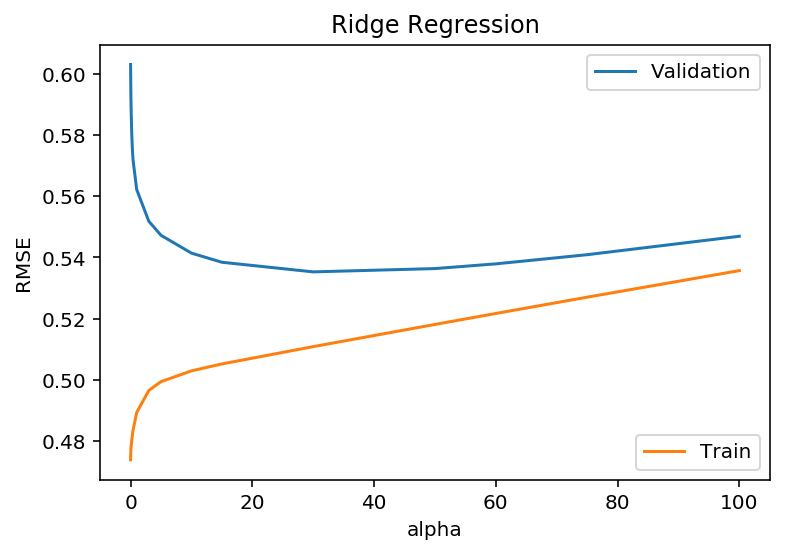

In [37]:
model_ridge = Ridge()
alphas = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 1, 3, 5, 10, 15, 30, 50, 60, 75, 100]
model_ridge = calc_rmse(model_ridge,"alpha",alphas,"Ridge Regression")

Treinamento do modelo de Regressão Linear Lasso, inclusive sem regularização (alpha = 0)

Lasso Regression - alpha versus RMSE 
           Train  Validation
0.003  0.482714    0.574865
0.005  0.487659    0.564373
0.100  0.521087    0.537572
0.250  0.569190    0.577810
0.500  0.701089    0.706249
1.000  0.843727    0.841662 



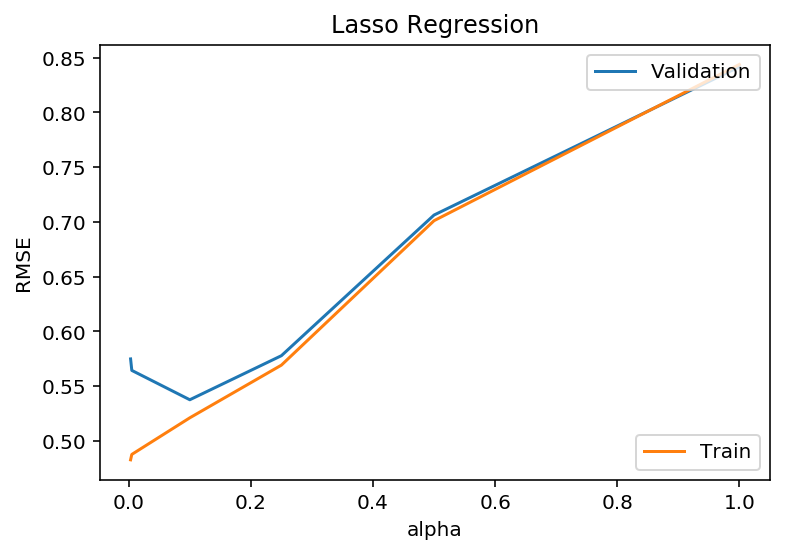

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
model_lasso = Lasso()
alphas = [0.003, 0.005, 0.1, 0.25, 0.5, 1]
calc_rmse(model_lasso,"alpha",alphas,"Lasso Regression")

Treinamento do modelo de regressão K-NN

KNN Regression - n_neighbors versus RMSE 
        Train  Validation
1   0.000000    0.725088
3   0.436453    0.577418
5   0.491966    0.555886
7   0.509990    0.554782
9   0.513919    0.557303
11  0.524216    0.548834 



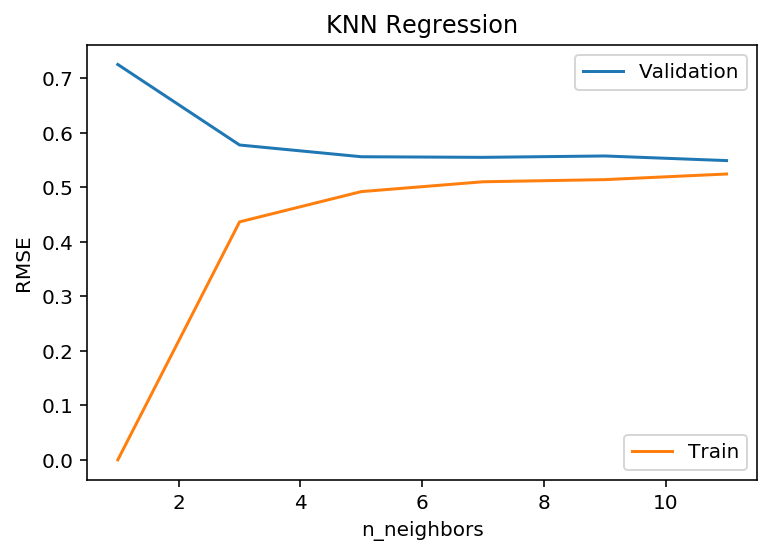

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=11, p=2,
          weights='uniform')

In [39]:
model_knn = KNeighborsRegressor()
n_neighbors = [1,3,5,7,9,11]
calc_rmse(model_knn,"n_neighbors",n_neighbors,"KNN Regression")

Treinamento do modelo de regressão Kernel Ridge

Kernel Ridge Regression - alpha versus RMSE 
             Train  Validation
0.0001   0.478241    0.602666
0.0010   0.478241    0.602456
0.1000   0.479386    0.586955
0.5000   0.486015    0.568193
1.0000   0.491437    0.561817
5.0000   0.507184    0.554247
10.0000  0.514501    0.552697
20.0000  0.522370    0.551791
30.0000  0.527475    0.551798
50.0000  0.534671    0.552802 



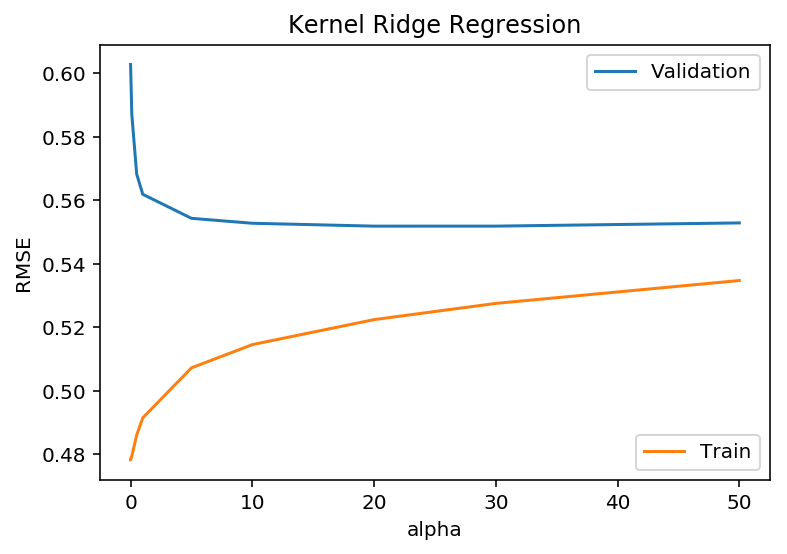

KernelRidge(alpha=20, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)

In [40]:
model_kernelridge = KernelRidge()
alphas = [0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 20, 30, 50]
calc_rmse(model_kernelridge,"alpha",alphas,"Kernel Ridge Regression")

Treinamento do modelo de regressão SVR

SVR - C versus RMSE 
          Train  Validation
5.00  0.191905    0.596284
2.00  0.307628    0.548812
1.00  0.375490    0.533789
0.10  0.608942    0.637092
0.01  0.804931    0.808863 



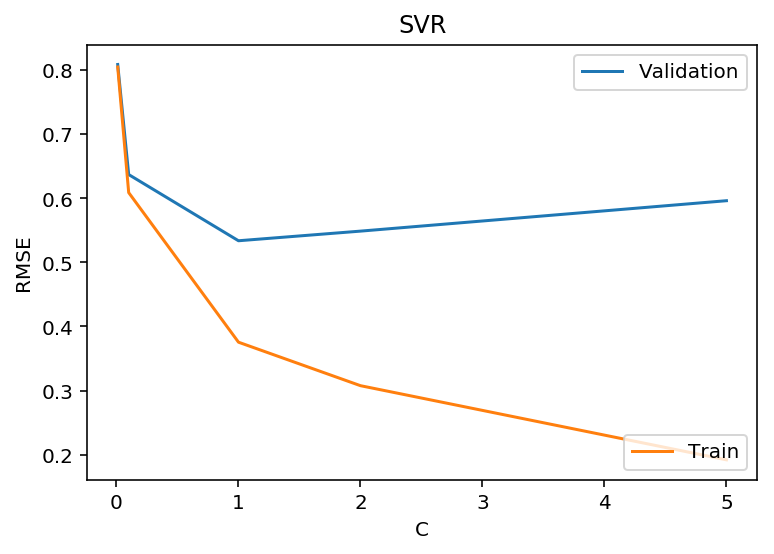

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [41]:
model_svr = SVR()
C = [5, 2, 1, 0.1, 0.01]
calc_rmse(model_svr,"C",C,"SVR")

Treinamento do modelo de Árvore de Regressão

Decision Tree Regression - min_samples_split versus RMSE 
        Train  Validation
2   0.000000    0.803052
5   0.163721    0.798974
10  0.304820    0.693073
15  0.364526    0.667782
20  0.402685    0.668558
25  0.424608    0.664434
50  0.509045    0.670204 



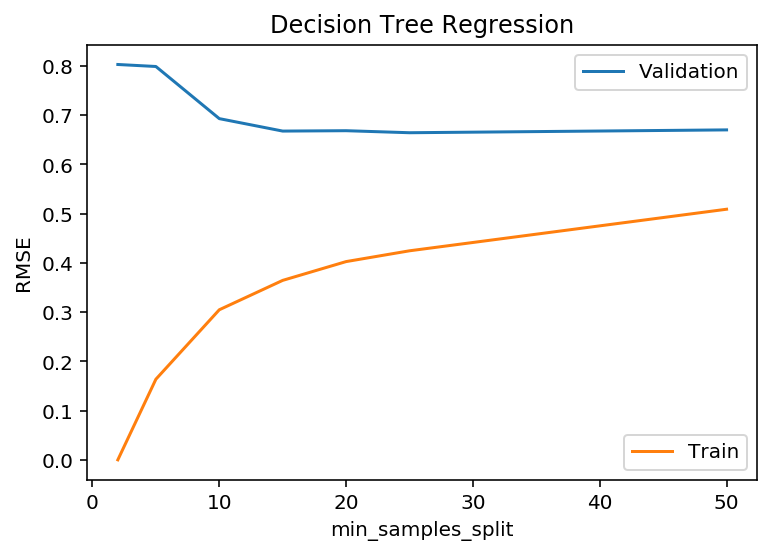

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=25,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [42]:
model_tree = DecisionTreeRegressor()
min_samples_split  = [2, 5, 10, 15, 20, 25, 50]
calc_rmse(model_tree,"min_samples_split",min_samples_split,"Decision Tree Regression")

Treinamento do modelo de Florestas Aleatórias de Regressão

Random Forest Regression - min_samples_split versus RMSE 
        Train  Validation
2   0.000000    0.848187
5   0.163721    0.795511
10  0.304820    0.687771
15  0.364526    0.666131
20  0.402685    0.668558
25  0.424608    0.664434 



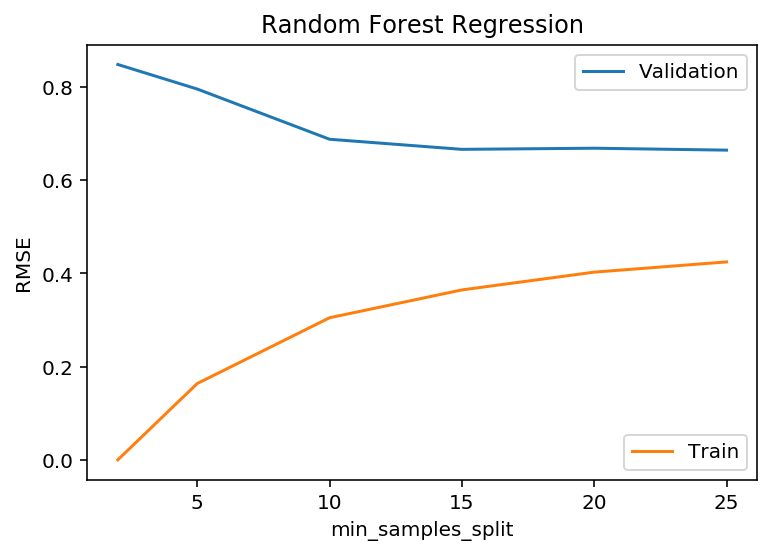

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=25,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [43]:
model_forest = RandomForestRegressor()
min_samples_split  = [2, 5, 10, 15, 20, 25]
calc_rmse(model_tree,"min_samples_split",min_samples_split,"Random Forest Regression")

Leitura dos dados de teste, adição da característica MEDIA aplicação da função log nos dados enviesados

In [44]:
[X_t,Y_t] = organize_test_data("graduados_teste.csv")
X_t = add_mean(X_t)
X_t[inclinacao] = np.log1p(X_t[inclinacao])

c:\users\danilo\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\danilo\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Treinamento do melhor modelo com os dados de validação (Regressão Ridge com alpha = 30), predição com os dados de teste e seu RMSE

In [48]:
model_ridge.fit(X,Y)
pred = model_ridge.predict(X_t)
print(np.sqrt(mean_squared_error(Y_t, pred)))

0.412308815718


Gráfico

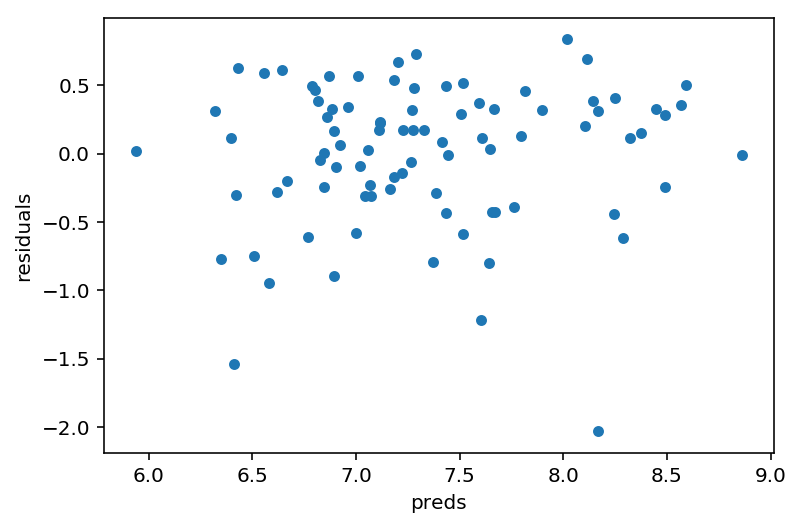

In [49]:
graph_res_pred(model_ridge,X,Y,"Ridge Regression")